<a href="https://colab.research.google.com/github/g13e/g13e.github.io/blob/master/nbs/dl_intro_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is based on the material provided as part of the **"Tensorflow in Practice"** and **"Tensorflow Data and Deployment"** specializations by deeplearning.ai. More info here 

https://www.deeplearning.ai/tensorflow-in-practice/

https://www.deeplearning.ai/tensorflow-data-and-deployment/


#Init and Utils

In [0]:
#select TensorFlow 2.x. It should soon become the default in colab, but for now it needs to be anually selected
try:
    %tensorflow_version 2.x
except:
    pass

In [0]:
# TensorFlow
import tensorflow as tf

# TensorFlow Datsets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Helper Libraries
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import csv

from os import getcwd
from google.colab import files

In [40]:
# check that TF 2.0 is being used and that runtime uses GPU. 
# TF 2.0 is required. GPU is recommended
print('\u2022 Using TensorFlow Version:', tf.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')


• Using TensorFlow Version: 2.1.0-rc1
• GPU Device Found.


#Dataset

For our examples we will use the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset of handwritten digits.

We will use [TensorFlow Datasets](https://www.tensorflow.org/datasets) to load the MNIST dataset. 

The tfds.load method downloads and caches the data, and returns a tf.data.Dataset object. These objects provide methods for manipulating data and piping it into your model. 


In [0]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

## Dataset Exploration

In [42]:
#let's explore the dimentionality of the data
print("train_images.shape:", train_images.shape)
print("train_images.min:",train_images.min())
print("train_images.max:",train_images.max())
print("train_labels.shape:",train_labels.shape) 
print("train_labels.min:",train_labels.min())
print("train_labels.max:",train_labels.max())

train_images.shape: (60000, 28, 28)
train_images.min: 0
train_images.max: 255
train_labels.shape: (60000,)
train_labels.min: 0
train_labels.max: 9


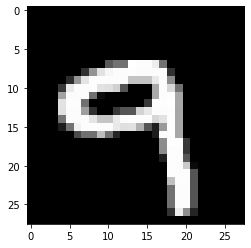

In [43]:
#@title Visualize the dataset { run: "auto" }

#let's visualize one of the images. 
#remember that the dataset is made up of 28*28 B/w pictures

index = 764 #@param {type:"slider", min:0, max:1000, step:1}
plt.rcParams['image.cmap'] = 'gray'
img = train_images[index]
plt.imshow(img);

# Dataset processing (normalization, batches, etc)

In [44]:
# normalize
def normalize(x, m, s): return (x-m)/s

mean,std = train_images.mean(),train_images.std()
train_images_norm = normalize(train_images, mean, std)

# NB: Use training, not validation mean for validation set
test_images_norm = normalize(test_images, mean, std)

#let's check that mean=0 and std=1
print("original:",train_images.mean(), train_images.std())
print("nomalized:",train_images_norm.mean(), train_images_norm.std())


original: 33.318421449829934 78.56748998339798
nomalized: -3.064638490070051e-17 0.9999999999999998


# Model (Network Architecture)

Here we create a Neural Network using the (high level) Keras API. A brief explanation of the main components:

**Sequential**: That defines a SEQUENCE of layers in the neural network

**Flatten**: takes a multidimention (in our case 2d) input and turns it into a 1 dimensional set (an array.

**Dense**: Just a regular layer of neurons for our Neural Net

Each layer of neurons needs an activation function to tell them what to do. There's lots of options, but for now we will use the following:

**Relu**: Rectified Linera Unit, effectively means "If X>0 return X, else return 0" -- so what it does it it only passes values 0 or greater to the next layer in the network.

**Softmax**: takes a set of values, and effectively picks the biggest one, so, for example, if the output of the last layer looks like [0.1, 0.1, 0.05, 0.1, 9.5, 0.1, 0.05, 0.05, 0.05], it will output [0,0,0,0,1,0,0,0,0]

In [0]:
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(), 
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])




The next thing to do is to build the model, by compiling it with an optimizer and loss function -- and then you train it by calling *model.fit * asking it to fit your training data to your training labels -- i.e. have it figure out the relationship between the training data and its actual labels, so in future if you have data that looks like the training data, then it can make a prediction for what that data would look like.

In [0]:
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [47]:
history= model.fit(train_images_norm, train_labels, 
                   batch_size=64,
                   epochs=5,
                   validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 3s 55us/sample - loss: 0.2639 - accuracy: 0.9199 - val_loss: 0.1469 - val_accuracy: 0.9553
Epoch 2/5
48000/48000 [==============================] - 2s 48us/sample - loss: 0.1158 - accuracy: 0.9660 - val_loss: 0.1049 - val_accuracy: 0.9689
Epoch 3/5
48000/48000 [==============================] - 2s 47us/sample - loss: 0.0792 - accuracy: 0.9759 - val_loss: 0.0929 - val_accuracy: 0.9716
Epoch 4/5
48000/48000 [==============================] - 2s 48us/sample - loss: 0.0587 - accuracy: 0.9818 - val_loss: 0.0940 - val_accuracy: 0.9705
Epoch 5/5
48000/48000 [==============================] - 2s 47us/sample - loss: 0.0473 - accuracy: 0.9852 - val_loss: 0.1075 - val_accuracy: 0.9678


we can also plot how accuracy and loss changes during training

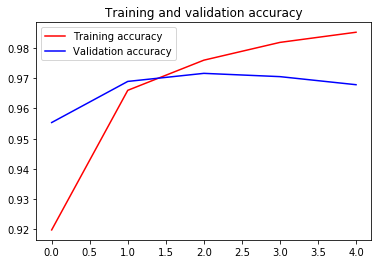

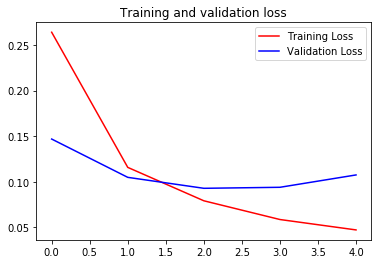

In [50]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Now let's check how the model is performing on the validation set

In [51]:
model.evaluate(test_images_norm, test_labels)

10000/10000 [==============================] - 1s 62us/sample - loss: 0.0952 - accuracy: 0.9698


[0.09522080259276554, 0.9698]

We can also check single examples

Predicted Digit: 4


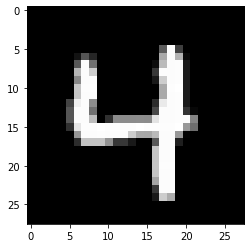

In [68]:
#@title Select test image { run: "auto" }

index = 722 #@param {type:"slider", min:0, max:1000, step:1}
plt.rcParams['image.cmap'] = 'gray'
img = test_images[index]
plt.imshow(img);       

#predict based 
im=np.expand_dims(img,axis=0)
im.shape
pred=model.predict(im)
digit=np.argmax(pred)
print("Predicted Digit:", digit)